# SVMスクラッチ

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

## 【問題1】ラグランジュの未定乗数法による最急降下

## 【問題2】サポートベクターの決定

## 【問題3】推定

In [2]:
class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル

    """

    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False, gamma=1, theta=0, d=1):
            # ハイパーパラメータを属性として記録
            self.iter = num_iter
            self.lr = lr
            self.kernel = kernel
            self.threshold = threshold
            self.verbose = verbose

            if self.kernel == "linear":
                self.kf = self.linear_kernel
            elif self.kernel == "polly":
                self.kf = self.polly_kernel

            self.gamma = gamma
            self.theta = theta
            self.d = d
            
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """

        self.lam = np.zeros(X.shape[0])

        for _ in range(self.iter):
            self.update_lam(X, y)
        self.sv(X, y)

        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
    
    def predict(self, X):
    
        """
        SVM分類器を使いラベルを推定

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        
        return np.sign(np.sum(self.lam_sv*self.y_sv*self.kf(X,self.X_sv), axis=1))
    
    def update_lam(self, X, y):
        """
        lam_new = np.zeros(self.lam.shape)
        for i in range(X.shape[0]):
            lam_new[i] = self.lam[i] + self.lr*(1-np.sum(self.lam*y[i]*y*(X[i]@X.T)))
        self.lam = lam_new.copy()
        """
        self.lam = self.lam + self.lr*(1-np.sum(self.lam*(y.reshape(-1,1))*y*self.kf(X,X), axis=1))
        
    def linear_kernel(self, x1, x2):
        return x1@x2.T
        
    def polly_kernel(self, x1, x2):
        return self.gamma*(x1@x2.T + self.theta)**self.d
    
    def sv(self, X, y):
        idx = np.arange(X.shape[0])
        self.index_support_vectors = idx[self.lam > self.threshold]
        self.n_support_vectors = self.index_support_vectors.shape[0]
        self.X_sv = X[self.index_support_vectors]
        self.lam_sv = self.lam[self.index_support_vectors]
        self.y_sv = y[self.index_support_vectors]



# 検証

## 【問題4】学習と推定

In [3]:
np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X_sample1 = np.concatenate((f0, f1))
y_sample1 = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X_sample1 = X_sample1[random_index]
y_sample1 = y_sample1[random_index]

In [4]:
X_train, X_test, y_train,y_test = train_test_split(X_sample1, y_sample1, test_size=0.3, random_state=0)

In [5]:
scratch_svm = ScratchSVMClassifier(num_iter=10, lr=0.001, kernel='linear', threshold=1e-5, verbose=False)

In [6]:
scratch_svm.fit(X_train,y_train)

In [7]:
y_pred = scratch_svm.predict(X_test)

In [8]:
print("accuracy:", precision_score(y_test, y_pred))
print("precision:", precision_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))
print("matrix\n:", confusion_matrix(y_test, y_pred))

accuracy: 1.0
precision: 1.0
recall: 1.0
matrix
: [[65  0]
 [ 0 85]]


## 【問題5】決定領域の可視化


In [9]:
def decision_region_svm(X, y, model, sv_enable=False, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue', 'yellow']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    if sv_enable == True:
        plt.scatter(model.X_sv[:, 0], model.X_sv[:, 1], s=80, color=scatter_color[-1], label="sv", marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()


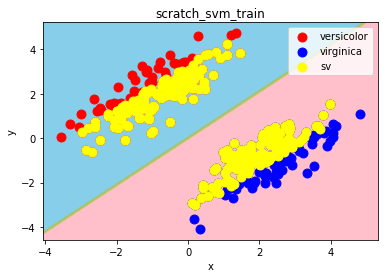

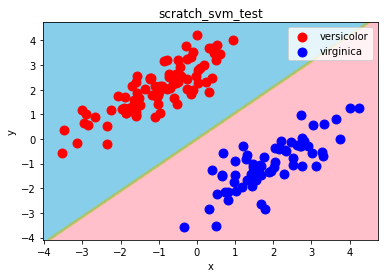

In [11]:
xlabel, ylabel = "x", "y"

decision_region_svm(X_train, y_train, scratch_svm, sv_enable=True, title='scratch_svm_train', xlabel=xlabel, ylabel=ylabel)
decision_region_svm(X_test, y_test, scratch_svm, sv_enable=False, title='scratch_svm_test', xlabel=xlabel, ylabel=ylabel)

